# Time Series Properties Deep Dive

**Objective:** Detailed investigation of time series properties to inform change point modeling decisions.

**Contents:**
1. Returns Analysis
2. Distribution Analysis
3. Regime Identification
4. Correlation with Events

In [11]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sys.path.append('../src')
from data_loader import BrentDataLoader, EventDataLoader
from time_series_analysis import TimeSeriesAnalyzer

os.makedirs("../outputs/figures", exist_ok=True)
sns.set_style('whitegrid')

In [12]:
# Force reload of modules (run this cell first!)
import sys
import importlib

# Remove cached modules
modules_to_reload = [key for key in sys.modules.keys() if 'data_loader' in key or 'time_series_analysis' in key]
for module in modules_to_reload:
    del sys.modules[module]

print("✓ Modules cleared from cache")


✓ Modules cleared from cache


## 1. Load Data

In [13]:
# Load price data
loader = BrentDataLoader(data_path='../data/events/BrentOilPrices.csv')
df = loader.load_data()
df = loader.preprocess()

# Load events
event_loader = EventDataLoader(events_path='../data/events/geopolitical_events.csv')
events_df = event_loader.load_events()

print(f"Price data: {len(df)} observations")
print(f"Events data: {len(events_df)} events")


Loaded 9011 records


c:\Users\HP\Desktop\Brent-Oil-Price-Analysis\notebooks\../src\data_loader.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  # Convert Date column to datetime (handle mixed formats)


Data preprocessed: 1987-05-20 00:00:00 to 2022-11-14 00:00:00
Loaded 18 events
Price data: 9011 observations
Events data: 18 events


## 2. Returns Distribution Analysis

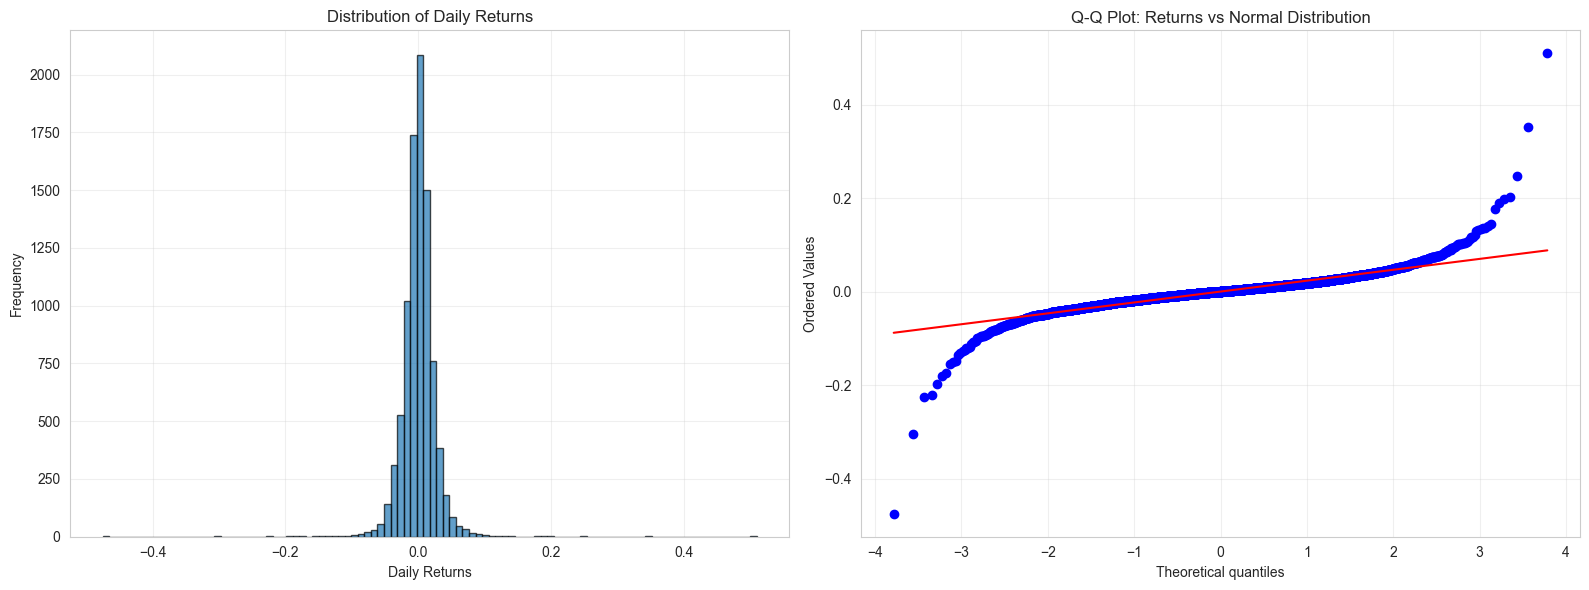


Shapiro-Wilk Test for Normality:
  Statistic: 0.8993
  P-value: 0.0000
  → Returns are NOT normally distributed (reject normality)

Skewness: 0.3116
Kurtosis: 45.4056

Note: Positive kurtosis indicates fat tails (more extreme events than normal distribution)


In [14]:
# Plot returns distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(df['Returns'].dropna(), bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Daily Returns')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Daily Returns')
axes[0].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(df['Returns'].dropna(), dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: Returns vs Normal Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../outputs/figures/returns_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# Test for normality
statistic, p_value = stats.shapiro(df['Returns'].dropna().sample(min(5000, len(df))))
print(f"\nShapiro-Wilk Test for Normality:")
print(f"  Statistic: {statistic:.4f}")
print(f"  P-value: {p_value:.4f}")
if p_value < 0.05:
    print("  → Returns are NOT normally distributed (reject normality)")
else:
    print("  → Returns appear normally distributed")

# Kurtosis and skewness
returns = df['Returns'].dropna()
print(f"\nSkewness: {stats.skew(returns):.4f}")
print(f"Kurtosis: {stats.kurtosis(returns):.4f}")
print("\nNote: Positive kurtosis indicates fat tails (more extreme events than normal distribution)")

## 3. Visual Regime Identification

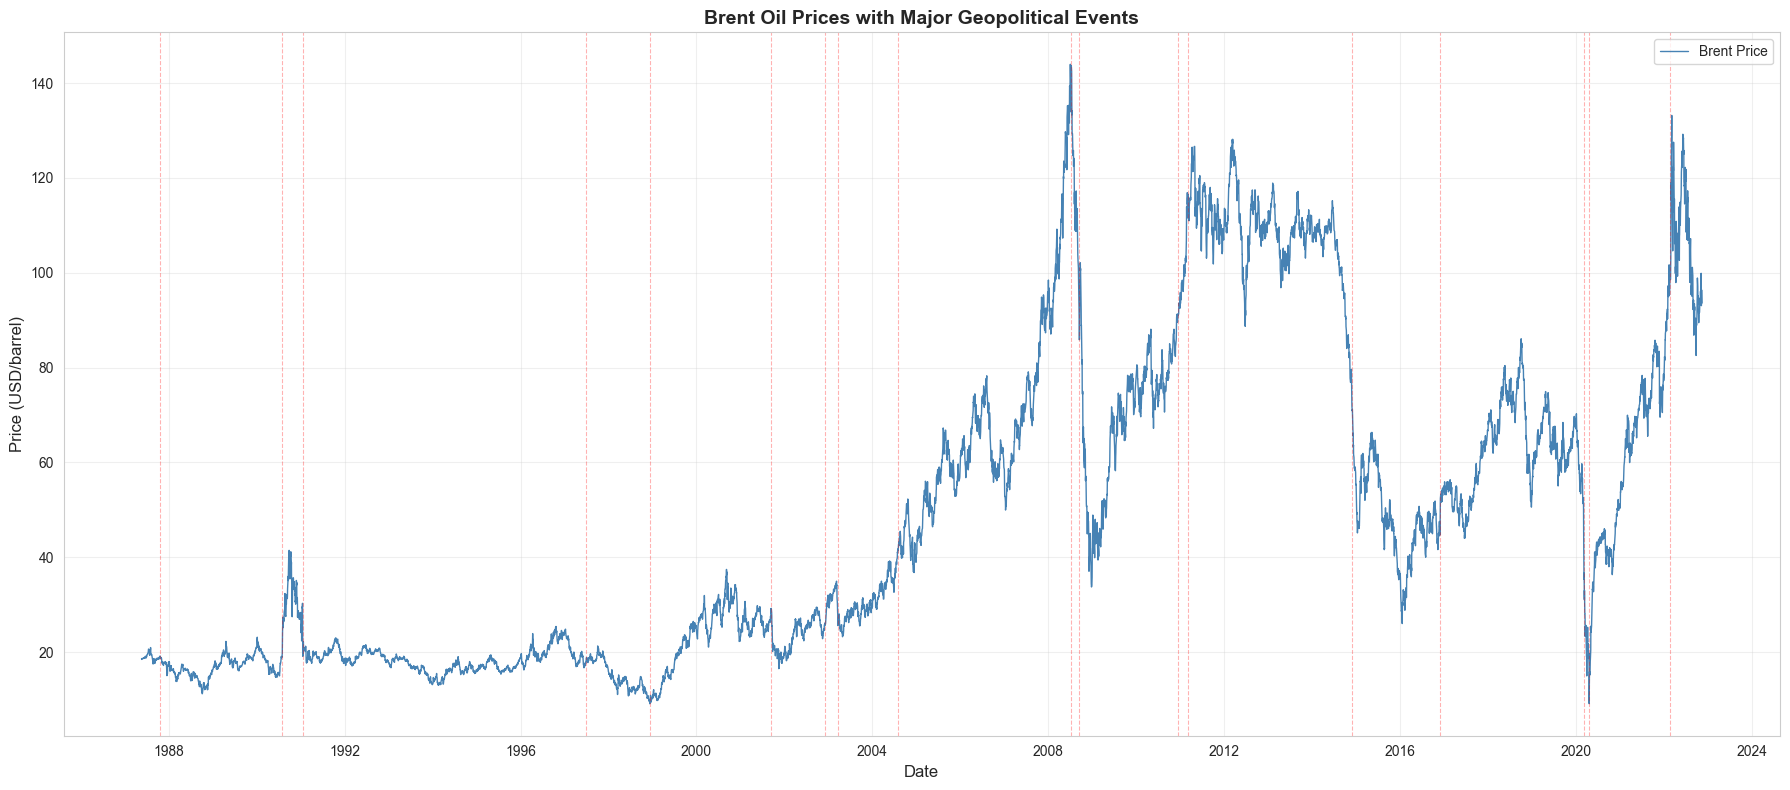


✓ Price with events plot saved


In [15]:
# Plot price with major events
fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(df['Date'], df['Price'], linewidth=1, color='steelblue', label='Brent Price')

# Mark major events
for _, event in events_df.iterrows():
    ax.axvline(event['Date'], color='red', alpha=0.3, linestyle='--', linewidth=0.8)
    
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USD/barrel)', fontsize=12)
ax.set_title('Brent Oil Prices with Major Geopolitical Events', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig("../outputs/figures/price_with_events.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Price with events plot saved")

## 4. Rolling Statistics Analysis

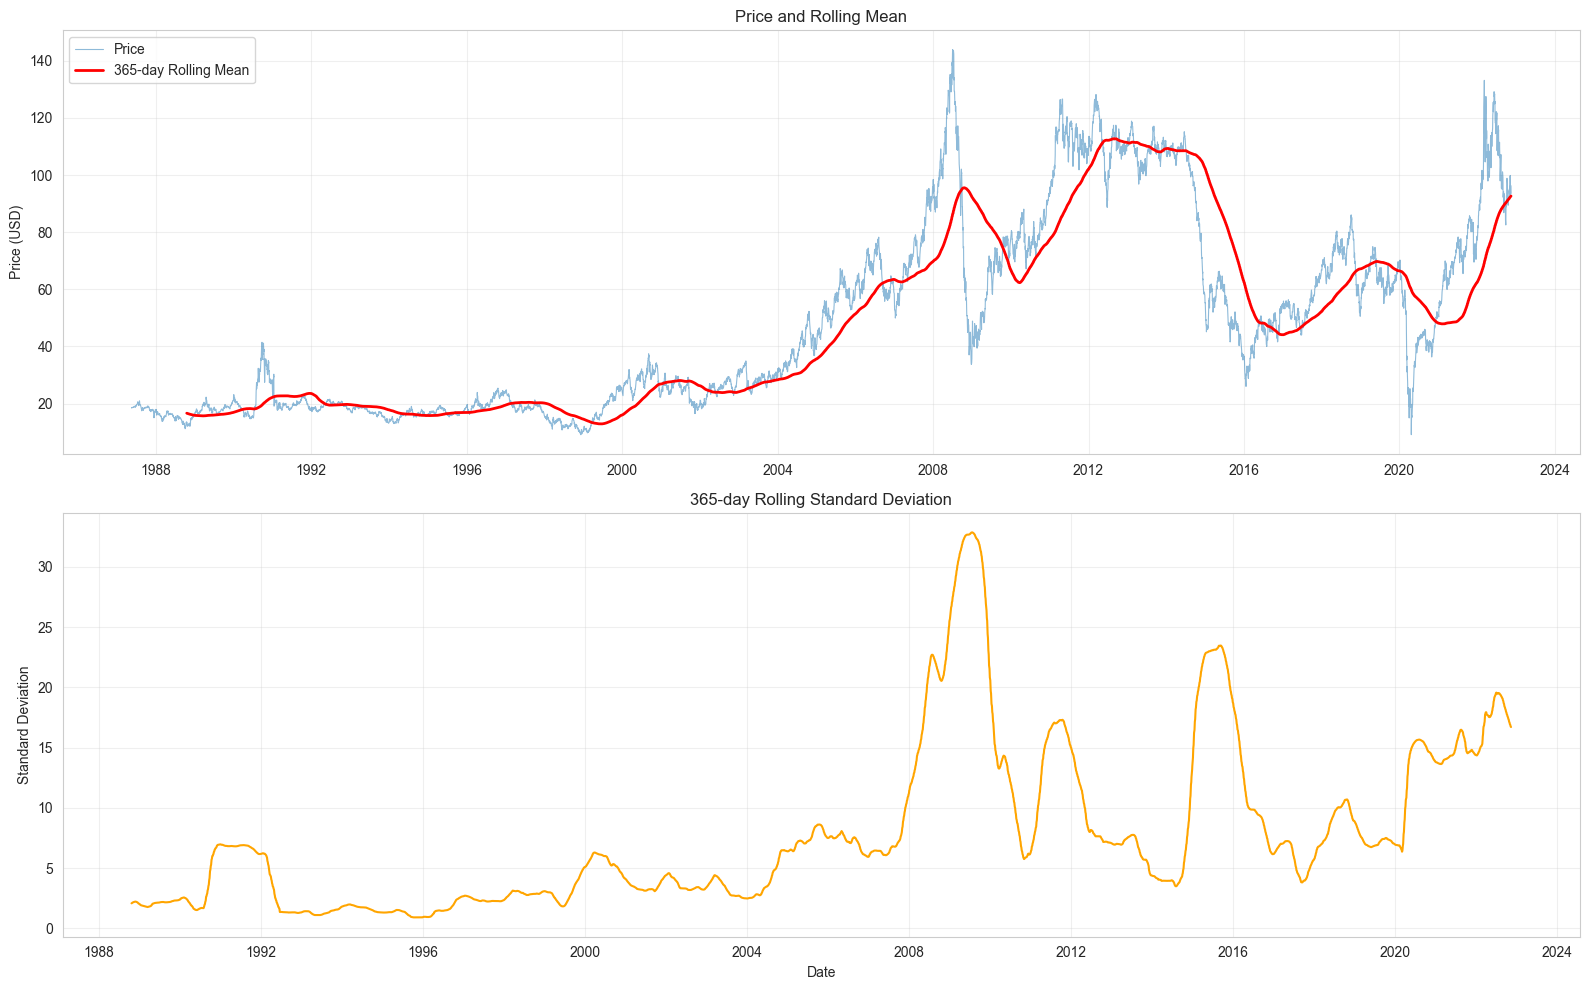

In [16]:
# Calculate rolling mean and std
window = 365
rolling_mean = df['Price'].rolling(window=window).mean()
rolling_std = df['Price'].rolling(window=window).std()

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Rolling mean
axes[0].plot(df['Date'], df['Price'], label='Price', alpha=0.5, linewidth=0.8)
axes[0].plot(df['Date'], rolling_mean, label=f'{window}-day Rolling Mean', 
             color='red', linewidth=2)
axes[0].set_ylabel('Price (USD)')
axes[0].set_title('Price and Rolling Mean')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Rolling std
axes[1].plot(df['Date'], rolling_std, color='orange', linewidth=1.5)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Standard Deviation')
axes[1].set_title(f'{window}-day Rolling Standard Deviation')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../outputs/figures/rolling_statistics.png", dpi=300, bbox_inches='tight')
plt.show()

## Summary: Implications for Change Point Modeling

### Key Findings:

1. **Non-Normal Returns Distribution**
   - Fat tails indicate more extreme events than normal distribution
   - Suggests need for robust modeling approach
   - Bayesian methods handle uncertainty well

2. **Clear Visual Regimes**
   - Multiple distinct price regimes visible
   - Regime changes often align with major events
   - Justifies change point detection approach

3. **Time-Varying Volatility**
   - Rolling statistics show changing variance
   - Model should capture variance shifts
   - Different regimes have different volatility levels

### Recommended Model Configuration:

1. **Number of Change Points:** 3-5 major breaks
2. **Parameters to Estimate:**
   - Change point locations (τ)
   - Regime means (μ)
   - Regime variances (σ²)
3. **Prior Specifications:**
   - Uniform priors for change point locations
   - Normal priors for means (centered on data mean)
   - Half-normal priors for standard deviations
4. **MCMC Configuration:**
   - 2000-5000 draws
   - 1000-2000 tuning steps
   - 2-4 chains for convergence assessment

### Next Steps:

Proceed to Notebook 03 for Bayesian change point model implementation.